In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

import matplotlib.colors as mcolors
import seaborn as sns
import itertools as it
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from scipy.stats import randint, uniform, loguniform

import warnings
warnings.filterwarnings('ignore')

/home/backslash/miniconda3/envs/ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def read_raw(fname):
    df = pd.read_csv(fname)
    dic = {"Rest":"D", "Preparation":"P", "Stroke": "S", "Hold": "H", "Retraction": "R"}
    
    df.phase = df.phase.apply(lambda x: dic[x])
    
    for col in df.columns:
        if col.endswith('x') or col.endswith('y') or col.endswith('z'):
             df[col] -= df['s' + col[-1]]
    
    df.drop(columns=['sx','sy','sz'], inplace=True)

    df = df.iloc[4:].reset_index(drop=True)
    phase = df.phase
    df.drop(columns='phase', inplace=True)
    
    df = (df-df.mean())/df.std()
    df = pd.concat((df, phase), axis=1)
    
    return df

def read_va3(fname, test=False):
    df = pd.read_csv(fname)

    if test:
        df = (df-df.mean())/df.std()
    else:
        df.rename(columns={'Phase':'phase'}, inplace=True)
        phase = df.phase
        df.drop(columns='phase', inplace=True)
        df = (df-df.mean())/df.std()
        df = pd.concat((df, phase), axis=1)
    
    return df

In [3]:
def MEGA_DATAFRAME(dirname):
    # creates a mega df that contains all dfs normalized and appended together
    # this is solely for the purpose of calculating the corr matrix but for training
    # youll need to train individually because its time series data, so it isnt continuous if youre doing tsa
    
    files = filter(lambda x: x.endswith('_va3.csv') or x.endswith('_raw.csv'), os.listdir(dirname))
    roots = [file.replace('_va3.csv', '').replace('_raw.csv', '') for file in files]
    for root in set(roots):
        roots.remove(root)
        # if any root is present only once (no counterpart) it is deleted
        # and those that have counterpart will stay

    MEGADF = []

    for root in roots:
        raw = read_raw(f'{dirname}/{root}_raw.csv')
        va3 = read_va3(f'{dirname}/{root}_va3.csv')
        
        df = pd.concat((raw.drop(columns='phase'), va3), axis=1)
        
        MEGADF.append(df)
        
    return pd.concat(MEGADF, axis=0), MEGADF

In [4]:
megadf, smalldfs = MEGA_DATAFRAME('data1')

In [10]:
data = megadf

In [5]:
# this is to intra compare a df, assumes data is the df youre analyising
classes = np.array(list(set(data.phase)))
idx = np.round(np.linspace(10, len(mcolors.CSS4_COLORS) - 10, len(classes))).astype(int)
colors = np.array(list(mcolors.CSS4_COLORS.keys()))[idx]

mapping = dict(zip(set(data.phase), colors))
print(mapping)

colorMap = list(map(lambda x: mapping[x], data.phase))
cols = data.drop(columns="phase").columns

for i in range(len(cols)):
    for j in range(i, len(cols)):
        column1 = cols[i]
        column2 = cols[j]
        if column1 == column2:
            for classs, color in zip(classes, colors):
                sns.kdeplot(data.where(data.phase==classs)[column1], color=color)
        else:
            plt.scatter(data[column1], data[column2], c=colorMap, alpha=0.4)  # You can adjust the number of bins as needed
        plt.xlabel(column1)
        plt.ylabel(column2)
        plt.plot()
        plt.show()

NameError: name 'data' is not defined

In [55]:
"""
myvel = data.drop(['phase'], axis=1).astype(float)
myvel = myvel[1:].reset_index(drop=True) - myvel[:-1].reset_index(drop=True)
delta_t = myvel.timestamp.copy()
myvel = myvel.div(delta_t, axis=0).drop('timestamp', axis=1)

myacc = myvel.copy()
myacc = myacc[1:].reset_index(drop=True) - myacc[:-1].reset_index(drop=True)
myacc = myacc.div(delta_t[1:].reset_index(drop=True), axis=0) # use the same delta_t and drop the first timestamp

myvel = myvel.iloc[1:].reset_index(drop=True) #drop first row for shape compatibility
myvel.columns = myvel.columns.str.cat(['v']*len(myvel.columns), sep="")
myacc.columns = myvel.columns.str.cat(['a']*len(myvel.columns), sep="")

scalarvel = [pd.Series(np.linalg.norm((myvel[x], myvel[y], myvel[z]), axis=0), name=x[:-2]+'v')
              for x, y, z in zip(myvel.columns[0::3], myvel.columns[1::3], myvel.columns[2::3])]
scalaracc = [pd.Series(np.linalg.norm((myacc[x], myacc[y], myacc[z]), axis=0), name=x[:-2]+'a')
              for x, y, z in zip(myacc.columns[0::3], myacc.columns[1::3], myacc.columns[2::3])]

pred_df = pd.concat((myvel, myacc, pd.concat((*scalarvel, *scalaracc), axis=1)), axis=1)
"""
None

[(0.00010966975150917306, 'rhy', 'rwy'),
 (0.00019138414030629638, 'lhy', 'lwy'),
 (0.0003318618422093633, 'rhx', 'rwx'),
 (0.0003662783058159522, '5', '11'),
 (0.00036642495841242843, '2', '8'),
 (0.0005090593277447741, '25', '27'),
 (0.0005204545285206976, '26', '28'),
 (0.0006558975865385404, 'lhx', 'lwx'),
 (0.0010527774178849183, '4', '10'),
 (0.0011862297019586843, '1', '7'),
 (0.0011940670219633142, 'rhz', 'rwz'),
 (0.0013193702926402376, 'lhz', 'lwz'),
 (0.002033332432456177, '6', '12'),
 (0.002040138050484882, '29', '31'),
 (0.0020683797910286835, '14', '20'),
 (0.002158934097748335, '3', '9'),
 (0.0032420091192589874, '17', '23'),
 (0.0033167476577793953, 'hy', 'hz'),
 (0.003476549184932348, '30', '32'),
 (0.004130180800506551, '13', '19')]

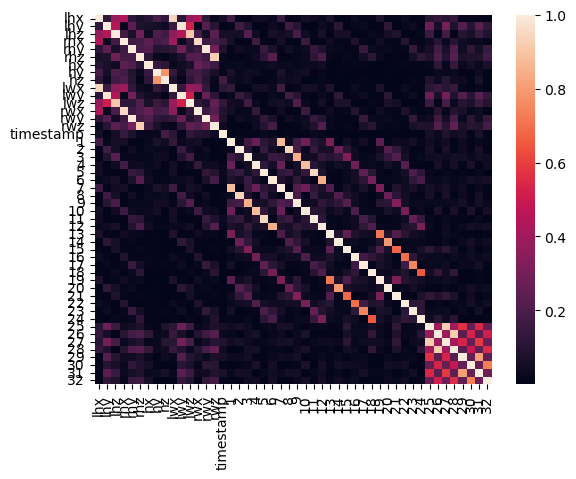

In [5]:
corrmat =abs( megadf.drop(columns='phase').corr() )
sns.heatmap(corrmat,  xticklabels=True, yticklabels=True)

# calculate the mse for each row with every other row
values=sorted([(((corrmat[i]-corrmat[j])**2).mean(), i, j) for i, j in it.combinations(corrmat, 2)])
values[:20]

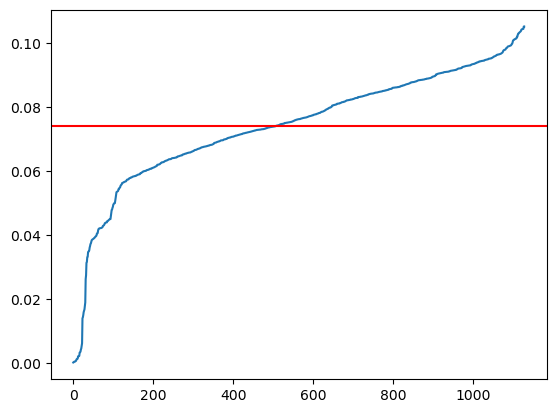

In [6]:
plt.plot([x[0] for x in values])
plt.axhline(y=np.mean([x[0] for x in values]),color='red')

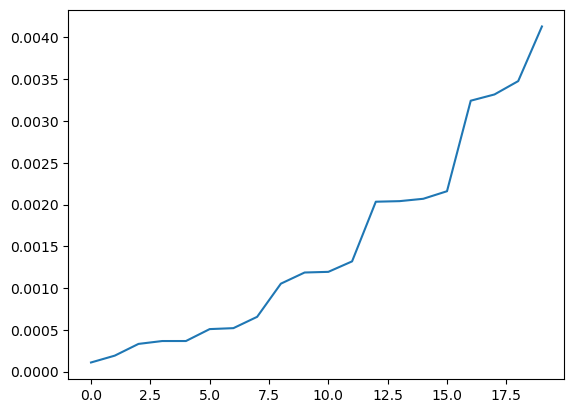

In [7]:
plt.plot([x[0] for x in values][:20])
# plt.axhline(y=np.mean([x[0] for x in values]),color='red')

In [8]:
# will drop the first 10 most similar features to reduce overfitting (will take average)
droppeddf = megadf.copy()
top_n = 23

features = list(set([feature for row in values[:top_n] for feature in row[1:]]))
# all paired features come sequentially
assert len(features) == top_n * 2, "features repeated!"

dropped_features = []

for feature1, feature2 in zip(features[::2], features[1::2]):
    print(feature1, feature2)
    droppeddf[feature1] = (droppeddf[feature1] + droppeddf[feature2])/2
    droppeddf.drop(columns=feature2, inplace=True)
    dropped_features.append(feature2)

6 21
rwy 13
4 30
lwx 7
rhx 12
3 16
rwz 14
1 24
32 8
19 20
29 15
22 26
lhy hy
23 lhx
18 27
9 10
17 25
11 hz
lhz rhy
lwz 31
2 rwx
lwy 5
rhz 28


In [10]:
droppeddf

,lhy,lhz,rhx,rhz,hx,hz,lwy,lwz,timestamp,1,...,12,13,15,19,20,21,25,26,28,phase
0,-0.170232,0.074111,0.083431,0.354410,-0.311813,0.153715,-0.062659,-0.242287,-1.643766,-0.007880,...,0.345898,-0.552881,-0.112755,0.018245,-0.397827,0.001552,-0.508300,-0.474050,-0.423848,D
1,0.712367,-0.046135,0.338568,0.317870,-0.296628,-0.454403,0.090569,0.303519,-1.642613,-0.574693,...,0.347569,-1.115002,0.511659,-1.152532,-0.256037,-0.142861,0.166020,-0.452272,-0.384214,D
2,-0.140734,0.155973,0.078054,0.356348,-0.290184,0.174653,-0.084195,0.514990,-1.641492,-0.014057,...,0.329586,0.044978,-0.518973,0.599671,1.012908,0.056326,-0.369705,-0.488356,-0.437300,D
3,-0.131246,0.122638,0.053803,0.395877,-0.279535,0.178398,-0.076757,-0.178103,-1.640563,0.033244,...,0.337044,-0.496814,-0.070594,-0.043363,-0.399051,-0.000702,-0.333042,-0.486226,-0.396316,D
4,0.351983,0.018245,0.152204,0.329231,-0.278399,0.590993,0.006417,0.267794,-1.639473,0.403187,...,0.324451,-0.141535,-0.319647,0.789835,0.698651,0.128909,-0.071887,-0.429564,-0.409176,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,0.287878,0.052525,0.060466,0.446932,0.343219,0.855118,0.161007,0.206342,1.720393,0.873643,...,0.582069,-0.152642,0.606155,-0.013172,0.144806,-0.129479,-0.108753,-0.031631,-0.515546,D
1416,0.406306,-0.073396,-0.042542,0.437259,0.471646,0.871717,0.043519,0.146749,1.722790,0.853708,...,0.573980,-0.161856,0.670061,0.153372,0.200621,0.100842,-0.006427,-0.038235,-0.478703,D
1417,0.396774,0.273552,-0.108398,0.503477,0.583656,0.776945,0.234986,0.078285,1.725405,0.755654,...,0.574384,-0.418821,0.711908,0.032430,-0.057021,0.151748,0.147029,0.005570,-0.292294,D
1418,0.492706,0.097782,-0.159099,0.512790,0.778709,0.952208,-0.003869,0.109002,1.727729,0.707157,...,0.569314,-0.294171,0.556631,0.799735,0.324657,0.118005,0.067455,-0.008220,-0.330403,D


In [9]:
def create_and_train_model(df):
    
    # start_row = 5
    # recent_data = df[start_row:] = a.flatten()
    label_encoder = LabelEncoder()

    X = np.array(df.drop(columns='phase'))
    y = label_encoder.fit_transform(data.phase)
    # y is numeric integer encoded

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier()

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train, test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
    print(f'train: {train} test: {test}')

    return label_encoder, model, test

In [ ]:
label_encoder, model = create_and_train_model(droppeddf)

In [10]:
def create_and_train_model_window(df, window_size=5, **params):

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df.phase.iloc[window_size-1:])
    # y is numeric integer encoded
    
    colcount = len(df.columns) - 1 #because phase
    rowcount = len(df)

    # creates sliding window
    indexer = np.arange(colcount*window_size)[None, :] + colcount*np.arange(rowcount-window_size+1)[:, None]
    X = np.array(df.drop(columns='phase')).flatten()[indexer]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier()
    model.set_params(**params)
    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train, test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
    print(f'train: {train} test: {test}')
    
    return label_encoder, model, test

In [ ]:
label_encoder, model, _ = create_and_train_model_window(droppeddf)

In [11]:
# search for the optimal number of dropped parameters for normal training
acc = []
for top_n in range(24):
    droppeddf = megadf.copy()
    
    features = list(set([feature for row in values[:top_n] for feature in row[1:]]))
    # all paired features come sequentially
    assert len(features) == top_n * 2, "features repeated!"
    
    dropped_features = []
    
    for feature1, feature2 in zip(features[::2], features[1::2]):
        droppeddf[feature1] = (droppeddf[feature1] + droppeddf[feature2])/2
        droppeddf.drop(columns=feature2, inplace=True)
        dropped_features.append(feature2)

    acc.append((top_n, create_and_train_model(droppeddf)[2]))

NameError: name 'data' is not defined

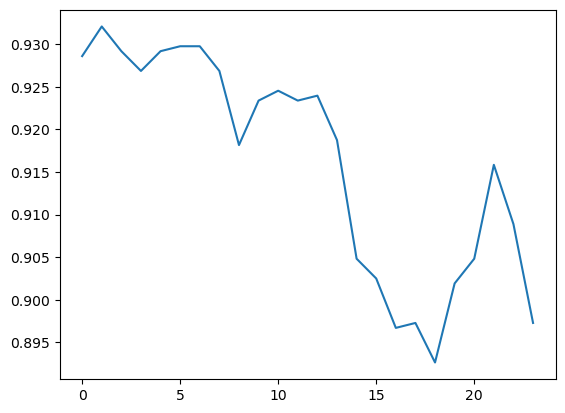

In [55]:
plt.plot(*list(zip(*acc)))

In [12]:
# search for the optimal number of dropped parameters for window training
acc = []
for top_n in range(24):
    droppeddf = megadf.copy()
    
    features = list(set([feature for row in values[:top_n] for feature in row[1:]]))
    # all paired features come sequentially
    assert len(features) == top_n * 2, "features repeated!"
    
    dropped_features = []
    
    for feature1, feature2 in zip(features[::2], features[1::2]):
        droppeddf[feature1] = (droppeddf[feature1] + droppeddf[feature2])/2
        droppeddf.drop(columns=feature2, inplace=True)
        dropped_features.append(feature2)

    acc.append((top_n, create_and_train_model_window(droppeddf)[2]))

[20:54:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

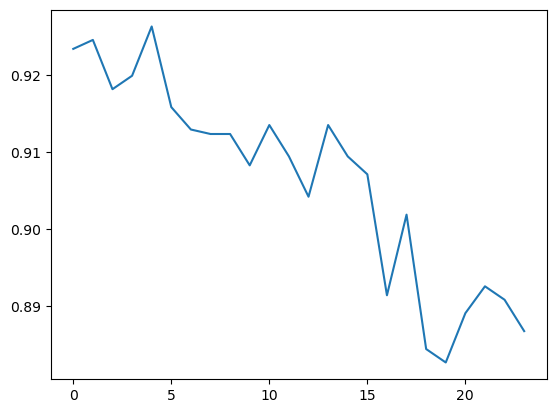

In [60]:
plt.plot(*list(zip(*acc)))

In [ ]:
# Optimal drop value is around 3

In [16]:
parameters = {
              'booster': ['gbtree', 'dart'],
              'grow_policy': ['depthwise', 'lossguide'],
              'learning_rate': uniform(0.1, 0.9),
              'gamma': loguniform(1e-12, 0.1),
              'max_depth': randint(1, 10),
              'min_child_weight': uniform(0, 5),
              'subsample': uniform(0.8, 0.2),
              'reg_lambda': loguniform(1e-9, 1e-2),
              'lambda': loguniform(1e-2, 2),
              'top_n': randint(0, 10),
              'window_size': randint(1, 16)
}

In [28]:
best_params = {'booster': 'dart',
               'grow_policy': 'lossguide',
               'learning_rate': 0.4780453234469396,
               'gamma': 2.619675093702632e-05,
               'max_depth': 5,
               'subsample': 0.9185962160353378,
               'min_child_weight': 0.06685960988065065, 
               'lambda': 0.06436748807909186, 
               'eval_metric': 'mlogloss', 
               'reg_lambda': 0.0036431473227940864, 
               'top_n': 0, 
               'window_size': 8
}


In [18]:
droppeddfs = []
for top_n in range(15):
    # search for the optimal number of dropped parameters for window training
    droppeddf = megadf.copy()
    
    features = list(set([feature for row in values[:top_n] for feature in row[1:]]))
    # all paired features come sequentially
    assert len(features) == top_n * 2, "features repeated!"

    dropped_features = []
    
    for feature1, feature2 in zip(features[::2], features[1::2]):
        droppeddf[feature1] = (droppeddf[feature1] + droppeddf[feature2])/2
        droppeddf.drop(columns=feature2, inplace=True)
        dropped_features.append(feature2)

    droppeddfs.append(droppeddf)

In [29]:
best_score = 0.9477351916376306

train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9367015098722415


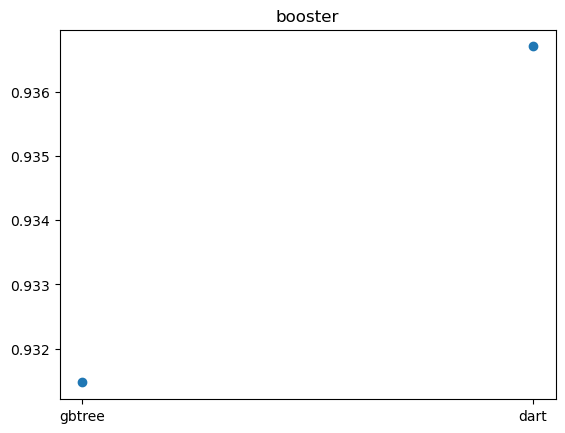

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


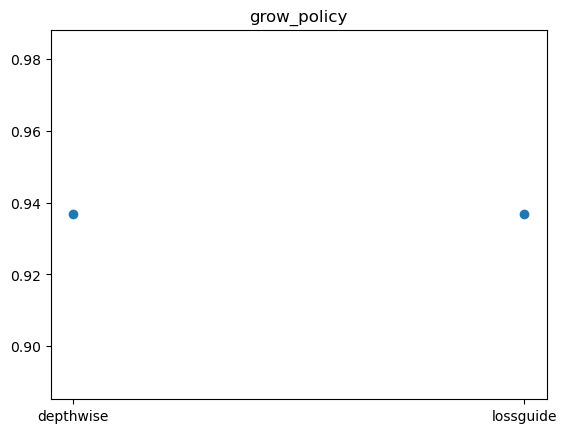

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9332171893147503
train: 1.0 test: 0.9303135888501742
train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9349593495934959


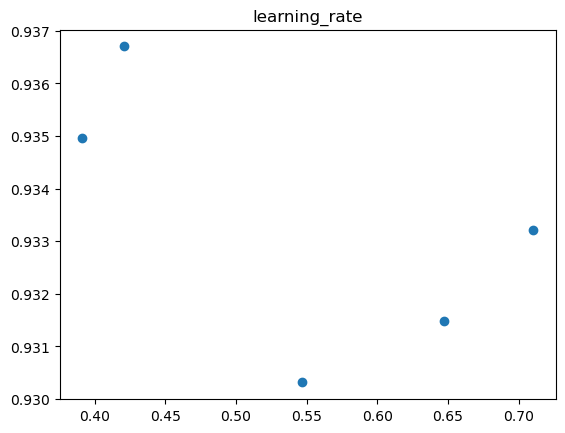

train: 1.0 test: 0.9349593495934959
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.926829268292683
train: 1.0 test: 0.9372822299651568


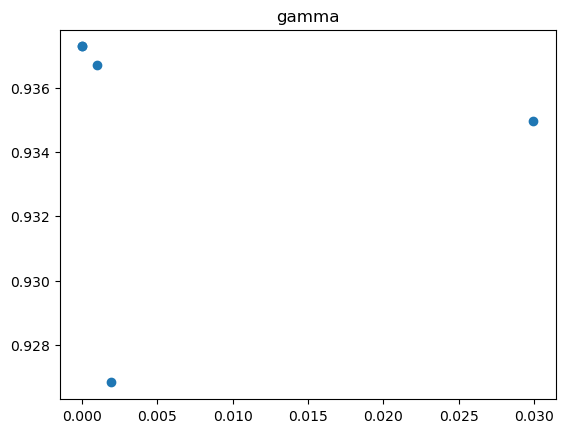

train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9314750290360047
train: 0.9616502033701336 test: 0.8623693379790941
train: 0.9616502033701336 test: 0.8623693379790941


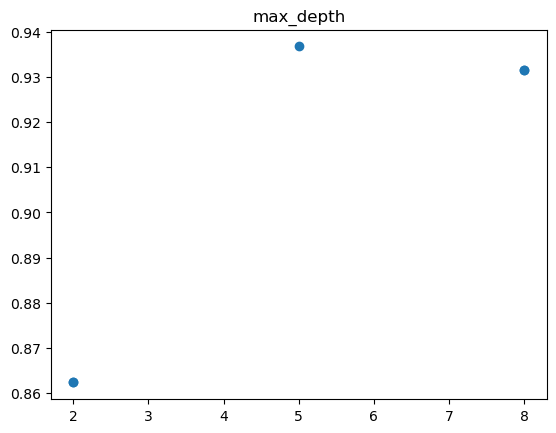

train: 1.0 test: 0.9361207897793263
train: 1.0 test: 0.9361207897793263
train: 1.0 test: 0.9285714285714286
train: 1.0 test: 0.9274099883855982
train: 1.0 test: 0.9308943089430894


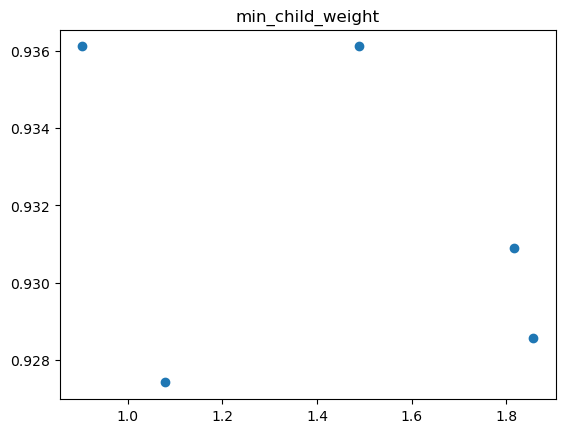

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9343786295005807
train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.9326364692218351
train: 1.0 test: 0.9326364692218351


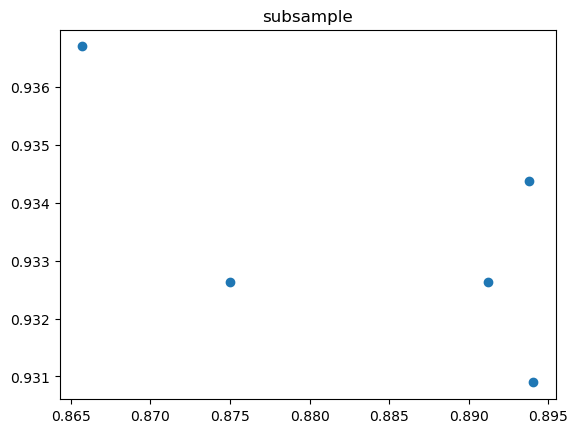

train: 1.0 test: 0.9361207897793263
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.937862950058072
train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.929732868757259


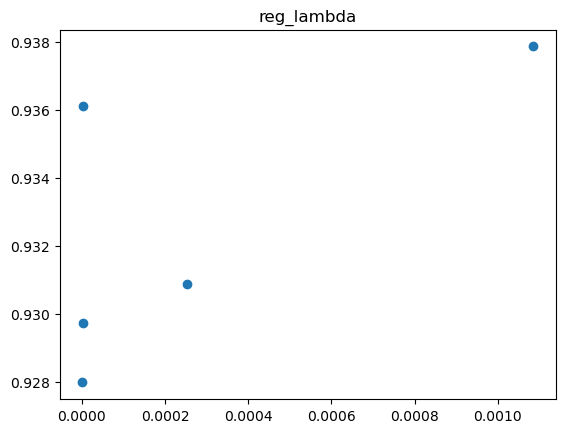

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


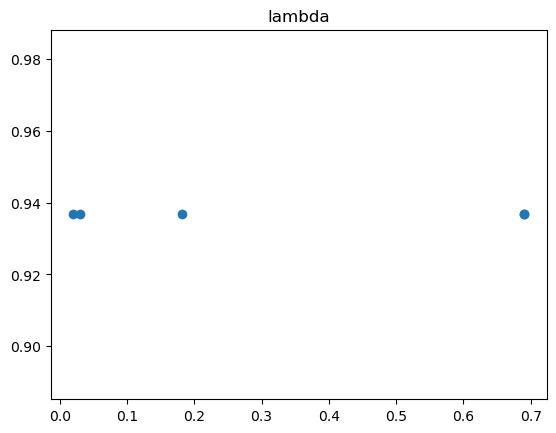

train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9285714285714286
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.9332171893147503


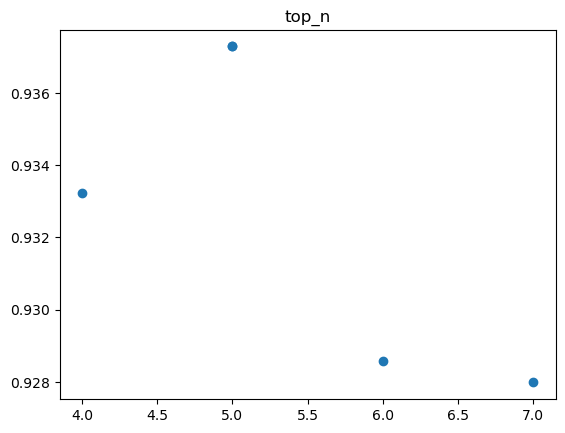

train: 1.0 test: 0.936664729808251
train: 1.0 test: 0.926871735345328
train: 1.0 test: 0.9343786295005807
train: 1.0 test: 0.9395700174317257
train: 1.0 test: 0.9367015098722415


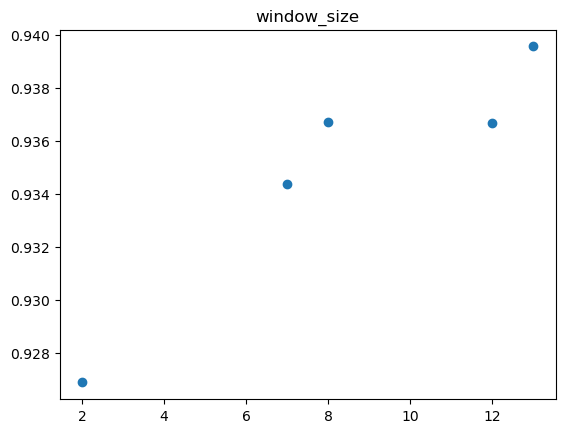

train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9367015098722415


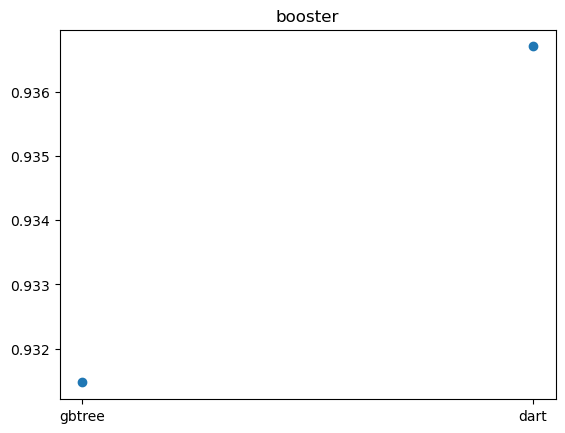

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


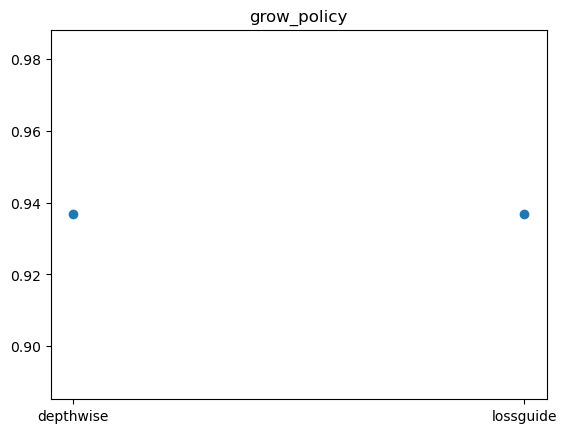

train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.924506387921022
train: 1.0 test: 0.9198606271777003
train: 1.0 test: 0.9320557491289199
train: 1.0 test: 0.9308943089430894


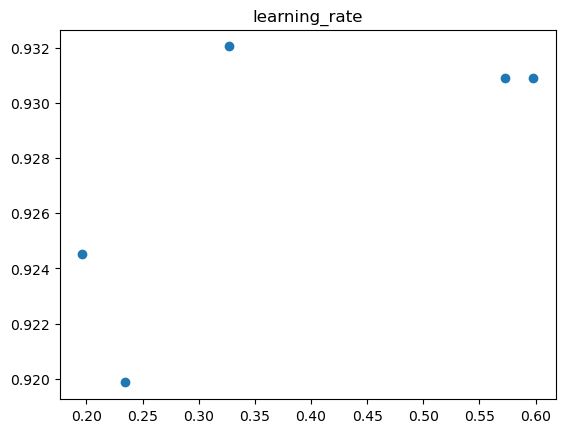

train: 1.0 test: 0.9337979094076655
train: 1.0 test: 0.929732868757259
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9372822299651568


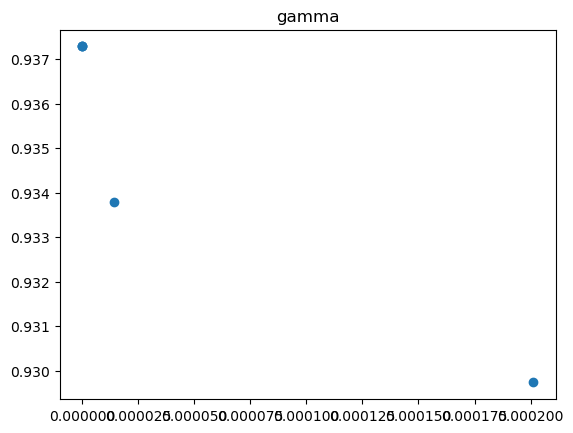

train: 1.0 test: 0.9320557491289199
train: 0.8065078442765834 test: 0.7537746806039489
train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.9367015098722415


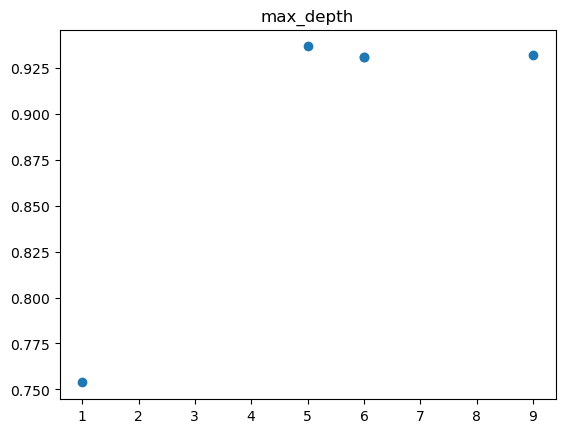

train: 1.0 test: 0.9256678281068524
train: 1.0 test: 0.929732868757259
train: 1.0 test: 0.926829268292683
train: 1.0 test: 0.929732868757259
train: 1.0 test: 0.9250871080139372


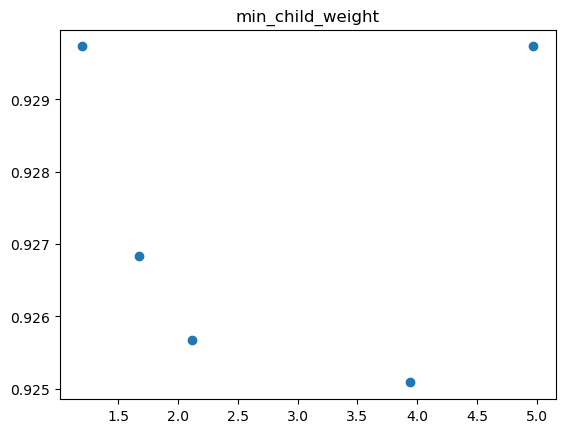

train: 1.0 test: 0.937862950058072
train: 1.0 test: 0.9326364692218351
train: 1.0 test: 0.9320557491289199
train: 1.0 test: 0.9343786295005807
train: 1.0 test: 0.929732868757259


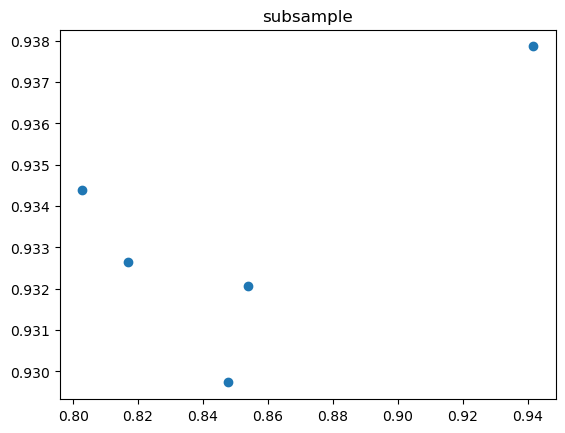

train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.929732868757259
train: 1.0 test: 0.9355400696864111
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.9279907084785134


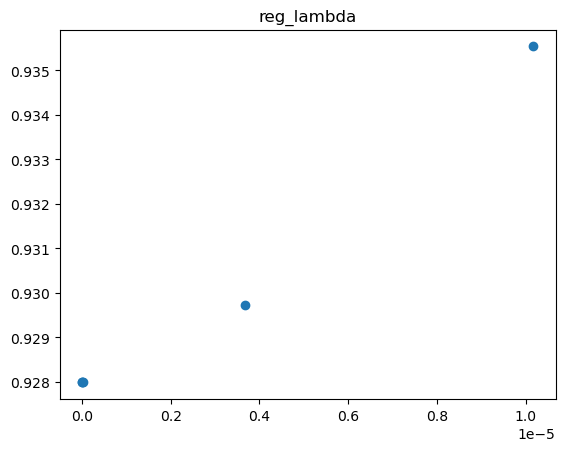

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


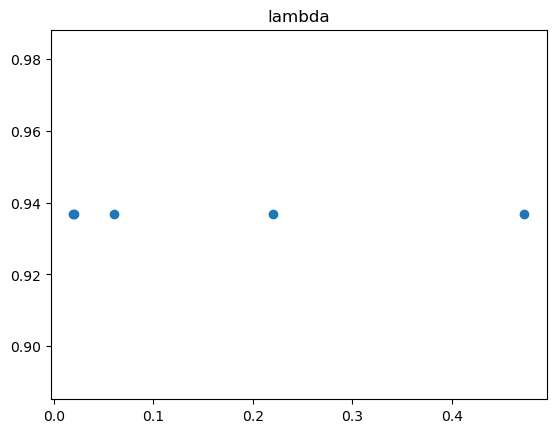

train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.9332171893147503
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.9250871080139372
train: 1.0 test: 0.9285714285714286


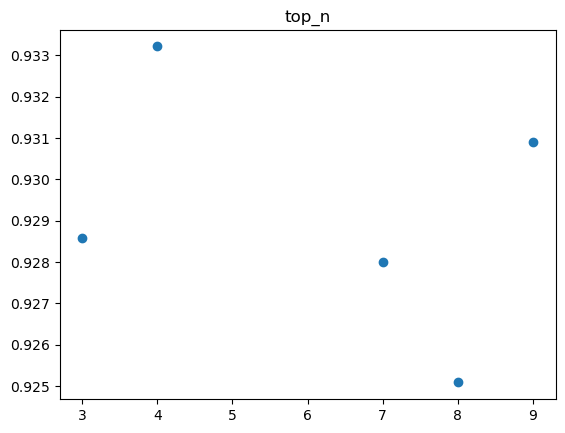

train: 1.0 test: 0.9192799070847851
train: 1.0 test: 0.9280325014509576
train: 1.0 test: 0.9203951191167926
train: 1.0 test: 0.926871735345328
train: 1.0 test: 0.9192799070847851


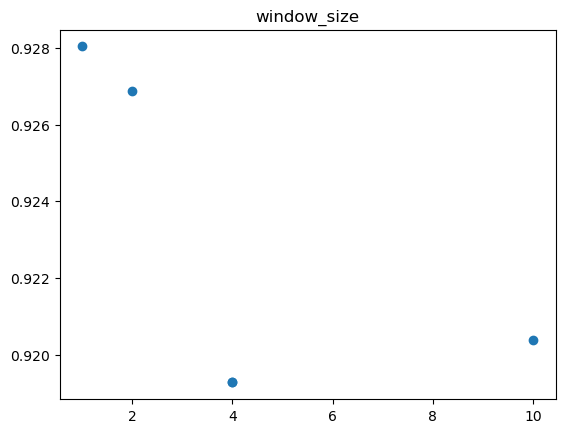

train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9367015098722415


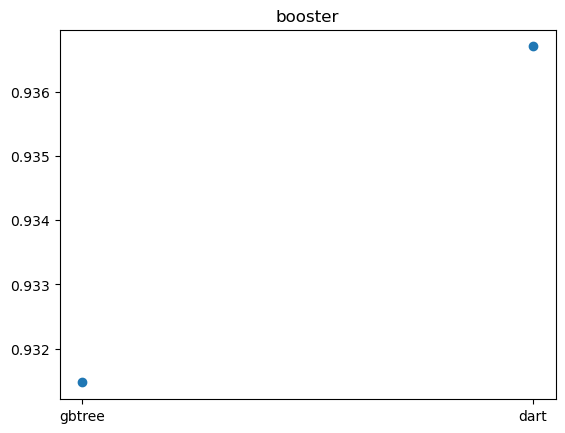

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


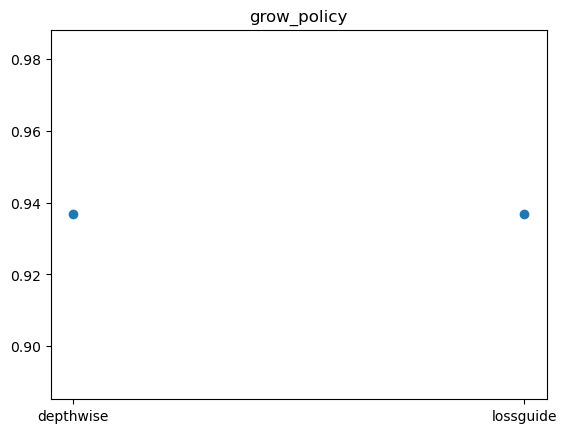

train: 1.0 test: 0.9262485481997678
train: 0.9055781522370715 test: 0.7311265969802555
train: 1.0 test: 0.9274099883855982
train: 1.0 test: 0.9303135888501742
train: 0.9205403834979663 test: 0.7282229965156795


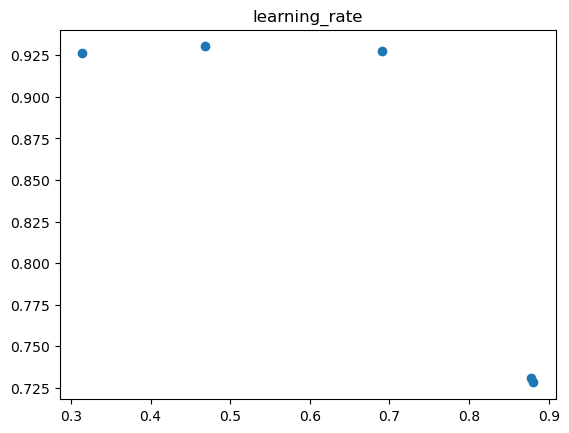

train: 1.0 test: 0.9361207897793263
train: 1.0 test: 0.9337979094076655
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9233449477351916
train: 1.0 test: 0.9337979094076655


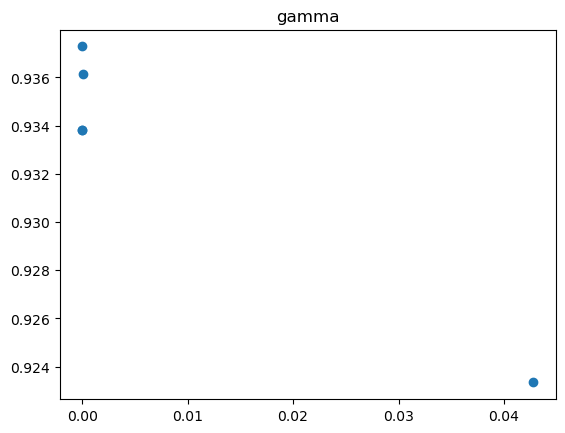

train: 1.0 test: 0.9320557491289199
train: 1.0 test: 0.9308943089430894
train: 1.0 test: 0.9308943089430894
train: 0.9998547356188263 test: 0.9047619047619048
train: 1.0 test: 0.9285714285714286


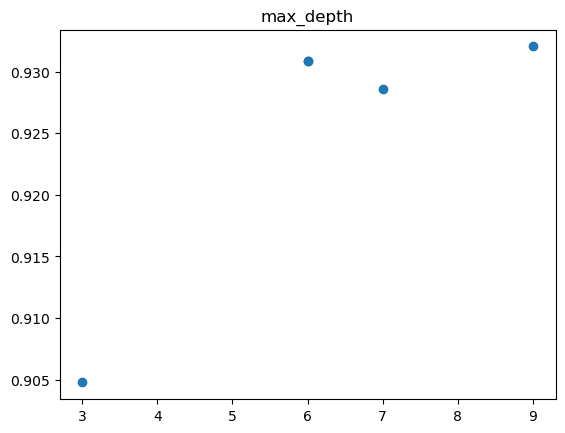

train: 1.0 test: 0.9320557491289199
train: 1.0 test: 0.9256678281068524
train: 1.0 test: 0.9384436701509872
train: 1.0 test: 0.926829268292683
train: 1.0 test: 0.9233449477351916


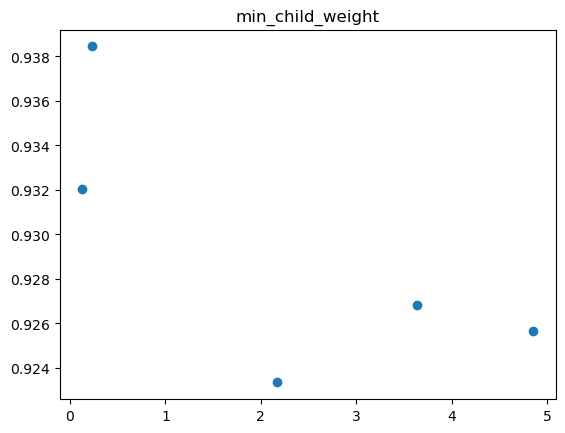

train: 1.0 test: 0.9291521486643438
train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9396051103368177
train: 1.0 test: 0.9320557491289199
train: 1.0 test: 0.9262485481997678


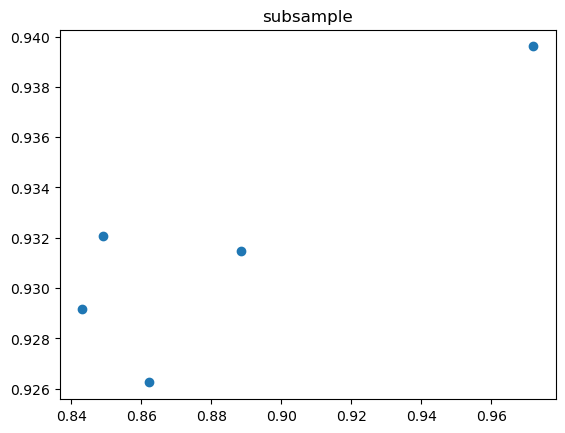

train: 1.0 test: 0.937862950058072
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.9291521486643438
train: 1.0 test: 0.9361207897793263


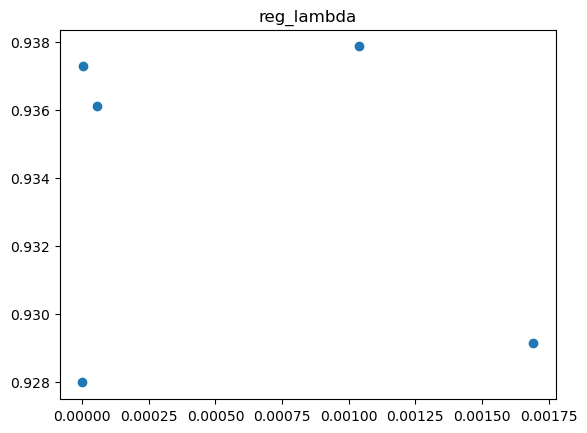

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


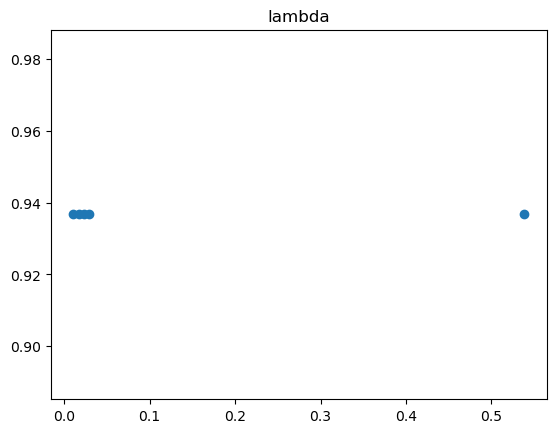

train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9250871080139372
train: 1.0 test: 0.9343786295005807
train: 1.0 test: 0.9285714285714286
train: 1.0 test: 0.9250871080139372


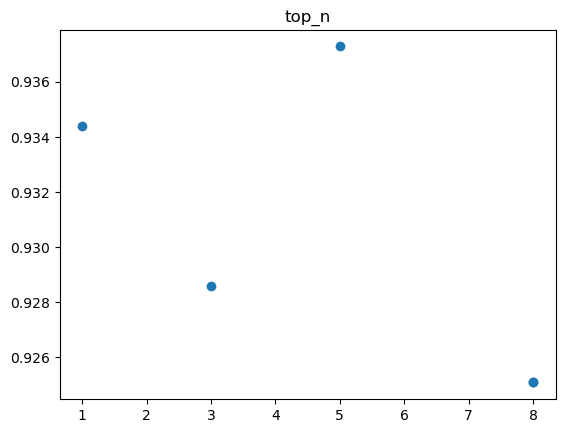

train: 1.0 test: 0.922809053975624
train: 1.0 test: 0.9290697674418604
train: 1.0 test: 0.9192799070847851
train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.936664729808251


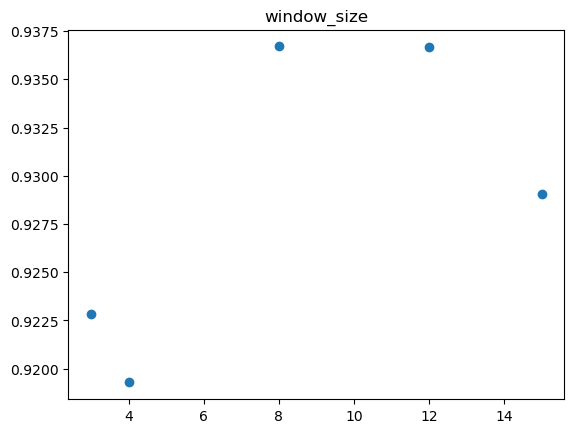

train: 1.0 test: 0.9314750290360047
train: 1.0 test: 0.9367015098722415


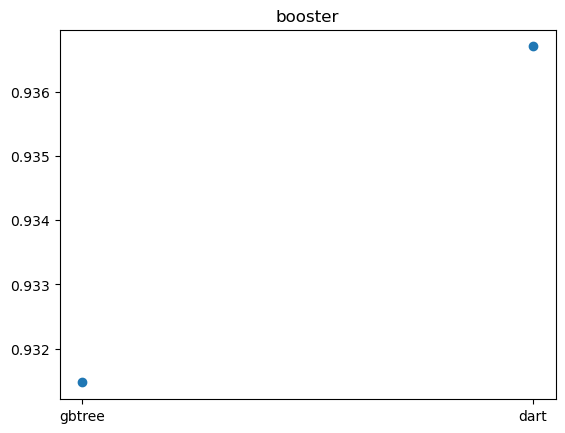

train: 1.0 test: 0.9367015098722415
train: 1.0 test: 0.9367015098722415


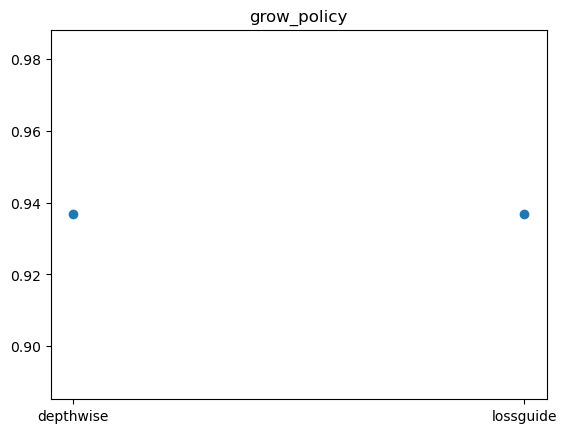

train: 1.0 test: 0.9361207897793263
train: 1.0 test: 0.9285714285714286
train: 1.0 test: 0.9274099883855982
train: 1.0 test: 0.9279907084785134
train: 1.0 test: 0.9361207897793263


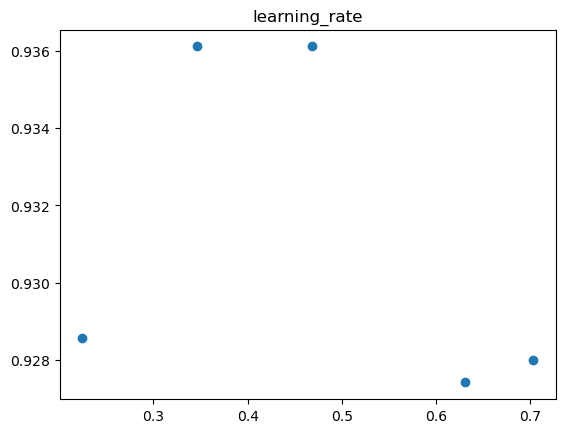

train: 1.0 test: 0.9326364692218351
train: 1.0 test: 0.9372822299651568
train: 1.0 test: 0.9308943089430894


KeyboardInterrupt: 

In [30]:
samples = []

while True:
    for hyp in parameters.keys():
        params = best_params.copy()
        xcors = []
        ycors = []

        if type(parameters[hyp]) == list:
            iterable = parameters[hyp]
        else:
            iterable = [parameters[hyp].rvs() for z in range(5)]
            
        for z in iterable:
            params[hyp] = z

            top_n       = params.pop('top_n')
            window_size = params.pop('window_size')

            # search for the optimal number of dropped parameters for window training
            droppeddf = droppeddfs[top_n]
            
            score = create_and_train_model_window(droppeddf, window_size, **params)[2]

            params['top_n'] = top_n
            params['window_size'] = window_size

            samples.append((params, score))
            
            xcors.append(params[hyp])
            ycors.append(score)

            if score >= best_score:
                if score>best_score:
                    print(score, params)
                best_score = score
                best_params = params.copy()
                
        plt.scatter(xcors, ycors)
        plt.title(hyp)
        plt.show()

In [31]:
best_params

{'booster': 'dart',
 'grow_policy': 'lossguide',
 'learning_rate': 0.4780453234469396,
 'gamma': 2.619675093702632e-05,
 'max_depth': 5,
 'subsample': 0.9185962160353378,
 'min_child_weight': 0.06685960988065065,
 'lambda': 0.06436748807909186,
 'eval_metric': 'mlogloss',
 'reg_lambda': 0.0036431473227940864,
 'top_n': 0,
 'window_size': 8}

In [88]:
def moving_avg(series, window_size, alpha=0.5):
    final = np.zeros((series.shape[0]+window_size-1, series.shape[1]))
    final[window_size-1:] = series
    final[:window_size-1] = final[window_size-1]

    for i in range(1, len(series)):
        final[i] = final[i]*(1-alpha) + final[i-1]*alpha

    print(final.shape)
    print(final)
    final = np.argmax(final, axis=1)
    
    return final

In [56]:
window_size = 8
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(megadf.phase.iloc[window_size-1:])
# y is numeric integer encoded

colcount = len(megadf.columns) - 1 #because phase
rowcount = len(megadf)

# creates sliding window
indexer = np.arange(colcount*window_size)[None, :] + colcount*np.arange(rowcount-window_size+1)[:, None]
X = np.array(megadf.drop(columns='phase')).flatten()[indexer]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.set_params(** {'booster': 'dart',
                     'grow_policy': 'lossguide',
                     'learning_rate': 0.4780453234469396,
                     'gamma': 2.619675093702632e-05,
                     'max_depth': 5,
                     'subsample': 0.9185962160353378,
                     'min_child_weight': 0.06685960988065065,
                     'lambda': 0.06436748807909186,
                     'eval_metric': 'mlogloss',
                     'reg_lambda': 0.0036431473227940864})

model.fit(X_train, y_train)

series = model.predict_proba(X)

In [64]:
xs = []
ys = []
for i in np.arange(0,1,0.01):
    y_moving = moving_avg(series, 5, i)
    xs.append(i)
    ys.append((y_moving == y).mean())

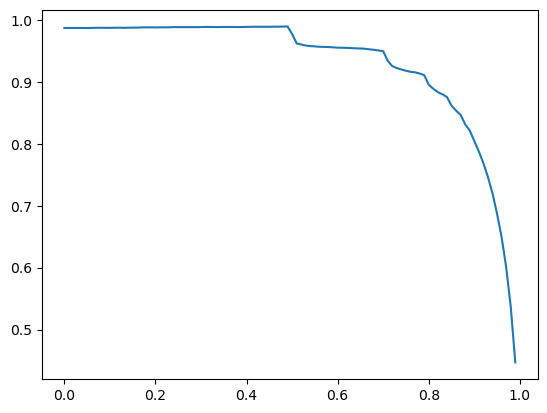

In [68]:
plt.plot(xs, ys)

In [69]:
xs[np.argmax(ys)]

0.49

In [ ]:
# 0.5 is ideal momentum

In [ ]:
def pred_test(model):
    raw = read_raw('data1/a2_raw.csv')
    va3 = read_va3('data1/test.csv', test=True)
    
    y_test = label_encoder.transform(raw.phase)
    
    df = pd.concat((raw.drop(columns='phase'), va3), axis=1).drop(columns=dropped_features)

    X = np.array(df)
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y_test, y_pred)

    index = pd.Index(range(1, len(y_pred)+1), name='ID')
    series = pd.Series(label_encoder.inverse_transform(y_pred), name='Phase', index=index)
    
    
    return series
    
pred_test(model).to_csv('submission.csv')

In [70]:
raw = read_raw('data1/a2_raw.csv')
va3 = read_va3('data1/test.csv', test=True)


y = label_encoder.fit_transform(megadf.phase.iloc[window_size-1:])
# y is numeric integer encoded

colcount = len(megadf.columns) - 1 #because phase
rowcount = len(megadf)

# creates sliding window
indexer = np.arange(colcount*window_size)[None, :] + colcount*np.arange(rowcount-window_size+1)[:, None]
X = np.array(megadf.drop(columns='phase')).flatten()[indexer]


model = XGBClassifier()
model.set_params(** {'booster': 'dart',
                     'grow_policy': 'lossguide',
                     'learning_rate': 0.4780453234469396,
                     'gamma': 2.619675093702632e-05,
                     'max_depth': 5,
                     'subsample': 0.9185962160353378,
                     'min_child_weight': 0.06685960988065065,
                     'lambda': 0.06436748807909186,
                     'eval_metric': 'mlogloss',
                     'reg_lambda': 0.0036431473227940864})

model.fit(X, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=2.619675093702632e-05, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=0.06436748807909186,
              learning_rate=0.4780453234469396, max_delta_step=0, max_depth=5,
              min_child_weight=0.06685960988065065, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.0036431473227940864,
              scale_pos_weight=None, subsample=0.9185962160353378,
              tree_method='exact', ...)

In [95]:
y_test = label_encoder.transform(raw.phase)

df = pd.concat((raw.drop(columns='phase'), va3), axis=1)

colcount = len(df.columns)
rowcount = len(df)

# creates sliding window
indexer = np.arange(colcount*window_size)[None, :] + colcount*np.arange(rowcount-window_size+1)[:, None]

X = np.array(df).flatten()[indexer]
y_pred = model.predict_proba(X)
y_pred = moving_avg(y_pred, window_size, 0)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

index = pd.Index(range(1, len(y_pred)+1), name='ID')
series = pd.Series(label_encoder.inverse_transform(y_pred), name='Phase', index=index)

series.to_csv('submission.csv')

(1260, 5)
[[7.21447170e-04 8.19188135e-05 9.95737195e-01 3.45453527e-03
  4.94209462e-06]
 [7.21447170e-04 8.19188135e-05 9.95737195e-01 3.45453527e-03
  4.94209462e-06]
 [7.21447170e-04 8.19188135e-05 9.95737195e-01 3.45453527e-03
  4.94209462e-06]
 ...
 [3.28248858e-01 8.70373624e-04 3.10517680e-02 6.05328143e-01
  3.45009118e-02]
 [4.38011825e-01 1.84433057e-03 1.08192459e-01 4.32118088e-01
  1.98332798e-02]
 [5.27304828e-01 1.32283152e-04 1.43918367e-02 4.43760127e-01
  1.44109651e-02]]
0.6468253968253969
